# Save time by reusing regridder

There is an important reason why the regridding is broken into two steps (making the regridder and perform regridding). For high-resolution grids, making the regridder (i.e. "computing regridding weights", explained later) is quite computationally expensive, but performing regridding on data ("applying regridding weights") is still pretty fast.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xesmf as xe

## Prepare data

The grids in previous examples were all quite small and the regridding was almost instantaneous. Let's try a large-ish grid here.

In [2]:
ds_in = xe.util.grid_2d(-120, 120, 0.4,  # longitude range and resolution
                        -60, 60, 0.3)  # latitude range and resolution
ds_in

<xarray.Dataset>
Dimensions:  (x: 600, x_b: 601, y: 400, y_b: 401)
Coordinates:
    lon      (y, x) float64 -119.8 -119.4 -119.0 -118.6 ... 119.0 119.4 119.8
    lat      (y, x) float64 -59.85 -59.85 -59.85 -59.85 ... 59.85 59.85 59.85
    lon_b    (y_b, x_b) float64 -120.0 -119.6 -119.2 ... 119.2 119.6 120.0
    lat_b    (y_b, x_b) float64 -60.0 -60.0 -60.0 -60.0 ... 60.0 60.0 60.0 60.0
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*

In [3]:
ds_out = xe.util.grid_2d(-120, 120, 0.6,
                         -60, 60, 0.4)
ds_out

<xarray.Dataset>
Dimensions:  (x: 400, x_b: 401, y: 300, y_b: 301)
Coordinates:
    lon      (y, x) float64 -119.7 -119.1 -118.5 -117.9 ... 118.5 119.1 119.7
    lat      (y, x) float64 -59.8 -59.8 -59.8 -59.8 ... 59.8 59.8 59.8 59.8
    lon_b    (y_b, x_b) float64 -120.0 -119.4 -118.8 ... 118.8 119.4 120.0
    lat_b    (y_b, x_b) float64 -60.0 -60.0 -60.0 -60.0 ... 60.0 60.0 60.0 60.0
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*

Also make a large-ish 4D data, with multiple time frames and vertical levels.

In [4]:
ds_in.coords['time'] = np.arange(1, 11)
ds_in.coords['lev'] = np.arange(1, 51)
ds_in['data2D'] = xe.data.wave_smooth(ds_in['lon'], ds_in['lat'])
ds_in['data4D'] = ds_in['time'] * ds_in['lev'] * ds_in['data2D']
ds_in

<xarray.Dataset>
Dimensions:  (lev: 50, time: 10, x: 600, x_b: 601, y: 400, y_b: 401)
Coordinates:
    lon      (y, x) float64 -119.8 -119.4 -119.0 -118.6 ... 119.0 119.4 119.8
    lat      (y, x) float64 -59.85 -59.85 -59.85 -59.85 ... 59.85 59.85 59.85
    lon_b    (y_b, x_b) float64 -120.0 -119.6 -119.2 ... 119.2 119.6 120.0
    lat_b    (y_b, x_b) float64 -60.0 -60.0 -60.0 -60.0 ... 60.0 60.0 60.0 60.0
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
  * lev      (lev) int64 1 2 3 4 5 6 7 8 9 10 ... 41 42 43 44 45 46 47 48 49 50
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    data2D   (y, x) float64 1.872 1.869 1.866 1.863 ... 1.863 1.866 1.869 1.872
    data4D   (time, lev, y, x) float64 1.872 1.869 1.866 ... 933.2 934.7 936.2

It is almost 1GB!

In [5]:
ds_in['data4D'].nbytes / 1e9 # Byte -> GB

0.96

The data itself is not too interesting... We only focus on performance here.

Text(0.5, 1.0, 'extra dimensions to test broadcasting')

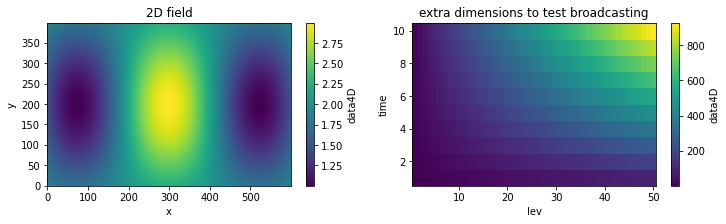

In [6]:
plt.figure(figsize=[12, 3])

plt.subplot(121)
ds_in['data4D'].isel(time=0, lev=0).plot()
plt.title('2D field')

plt.subplot(122)
ds_in['data4D'].mean(dim=['x','y']).plot()
plt.title('extra dimensions to test broadcasting')

## Build Regridder

Making a bilinear regridder takes ~7s on my Mac! (`'conservative'` would take even longer. Try it yourself.)

In [7]:
%%time
regridder = xe.Regridder(ds_in, ds_out, 'bilinear')

CPU times: user 3.89 s, sys: 169 ms, total: 4.05 s
Wall time: 4.07 s


In [8]:
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Input grid shape:           (400, 600) 
Output grid shape:          (300, 400) 
Output grid dimension name: ('y', 'x') 
Periodic in longitude?      False

## Apply regridding

However, applying the regridder to 1GB of data only takes ~0.5s

In [9]:
%%time
dr_out = regridder(ds_in['data4D'])

CPU times: user 429 ms, sys: 165 ms, total: 594 ms
Wall time: 593 ms


## Why applying regridding is so fast?

Most regridding algorithms (including all 5 algorithms in ESMF) are linear, i.e. the output data field is linearly dependent on the input data field. Any linear transform can be viewed as a matrix-vector multiplication $y = Ax$, where $A$ is a matrix containing **regridding weights**, and $x$, $y$ are input and output data fields flatten to 1D.

Computing the **weight matrix** $A$ is expensive, but $A$ **only depends on input and output grids**, not on input data. That means we can use the same $A$ on different input fields $x$, as long as the grid structure is not changed. 

An xESMF regridder has an attribute `weights`, i.e. the weight matrix.

In [10]:
regridder.weights

<120000x240000 sparse matrix of type '<class 'numpy.float64'>'
	with 480000 stored elements in COOrdinate format>

It is typically very sparse, because a single destination point will only receive contribution from a small number of source points.

Text(0, 0.5, 'output grid indices')

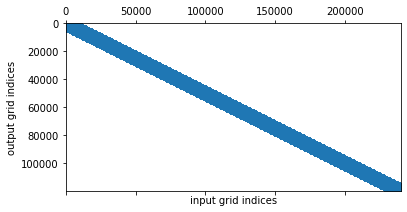

In [11]:
plt.spy(regridder.weights)
plt.xlabel('input grid indices')
plt.ylabel('output grid indices')

## Retrieve regridder

To avoid recomputing the same weights later, you can write the weights to disk and reload them later. First write the weights using the `to_netcdf` method. A default file name will be chosen if none is given.

In [12]:
fn = regridder.to_netcdf()
print(fn)

bilinear_400x600_300x400.nc


In [13]:
%%bash
du -sh bilinear_400x600_300x400.nc

7.4M	bilinear_400x600_300x400.nc


When you open the notebook next time, simply set the `weights` argument to the path to the netCDF file. The weight file is typically pretty small (due to sparsity), so reading it is almost instantaneous.

In [14]:
%%time
regridder2 = xe.Regridder(ds_in, ds_out, 'bilinear', weights=fn)

CPU times: user 24.3 ms, sys: 0 ns, total: 24.3 ms
Wall time: 23 ms


The second-step, applying those weights to data, is just a matrix multiplication $y=Ax$. With highly-optimized sparse matrix multiplication library, it is blazingly fast.

In [15]:
%%time
dr_out2 = regridder2(ds_in['data4D'])

CPU times: user 426 ms, sys: 172 ms, total: 598 ms
Wall time: 597 ms


The retrieved regridder gives the same result as the first regridder.

In [16]:
xr.testing.assert_identical(dr_out, dr_out2)  # they are equal

For even larger grids, you might spend several minutes computing the weights. But once they are computed, you don't have to do it again.